# Part 3. Building a model

In [2]:
from ipynb.fs.defs.part2_data_prep import load_dataset

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf 

In [3]:
x_train, y_train = load_dataset("./data/chest_xray/train/", 6000)
x_test, y_test = load_dataset("./data/chest_xray/test/", 6000)
x_val, y_val = load_dataset("./data/chest_xray/val/", 6000)

Finished reading the dataset
Finished reading the dataset
Finished reading the dataset


(5216, 150, 150, 3)


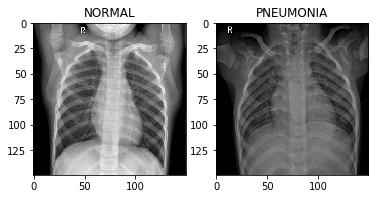

In [9]:
print(train_imgs.shape)

plt.subplot(1,2,1).set_title('NORMAL')
plt.imshow(train_imgs[np.argmax(train_labels == 0)])

plt.subplot(1,2,2).set_title('PNEUMONIA')
plt.imshow(train_imgs[np.argmax(train_labels == 1)])

![](https://cdn-images-1.medium.com/max/1600/1*cufAO77aeSWdShs3ba5ndg.jpeg)

In [4]:
from sklearn.utils import class_weight

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16

NUM_CLASSES = 2

base_model = VGG16(weights ='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [6]:
def print_layers(model):
    for idx, layer in enumerate(model.layers):
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

In [7]:
# Train only the bottom layers 
for layer in base_model.layers:
    layer.trainable = False
    
print_layers(model)

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_pool, trainable: False
layer 11: block4_conv1, trainable: False
layer 12: block4_conv2, trainable: False
layer 13: block4_conv3, trainable: False
layer 14: block4_pool, trainable: False
layer 15: block5_conv1, trainable: False
layer 16: block5_conv2, trainable: False
layer 17: block5_conv3, trainable: False
layer 18: block5_pool, trainable: False
layer 19: flatten_1, trainable: True
layer 20: dense_1, trainable: True


In [8]:
optimizer_sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',     
              optimizer=optimizer_sgd, 
              metrics=['accuracy'])

In [9]:
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_acc', 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    verbose=1
)

tensorboard = TensorBoard(
    log_dir='./Graph', 
    histogram_freq=0,  
    write_graph=True
)

lr_reduce = ReduceLROnPlateau(
    monitor='val_acc', 
    factor=0.1, 
    epsilon=0.0001, 
    patience=1, 
    verbose=1
)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [ ]:
%%timeit

history = model.fit(
    x = x_train, y = y_train,
    validation_data = (x_test, y_test),
    #class_weight=classweight,
    callbacks=[checkpoint, tensorboard, lr_reduce],
    shuffle=True,
    batch_size=64,
    epochs=10,
    verbose=1
)

Train on 5216 samples, validate on 624 samples
Epoch 1/10
5216/5216 [==============================] - 9s 2ms/step - loss: 1.9277 - acc: 0.8737 - val_loss: 3.6005 - val_acc: 0.7708

Epoch 00001: val_acc improved from -inf to 0.77083, saving model to best_model.h5
Epoch 2/10
5216/5216 [==============================] - 5s 956us/step - loss: 1.2900 - acc: 0.9181 - val_loss: 4.3369 - val_acc: 0.7308

Epoch 00002: val_acc did not improve from 0.77083

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/10
5216/5216 [==============================] - 5s 956us/step - loss: 1.1040 - acc: 0.9293 - val_loss: 4.3446 - val_acc: 0.7276

Epoch 00003: val_acc did not improve from 0.77083

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 4/10
5216/5216 [==============================] - 5s 966us/step - loss: 1.1040 - acc: 0.9296 - val_loss: 4.3174 - val_acc: 0.7292

Epoch 00004: val_acc did not improve from 0.77083

Epoch 0000

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Model accuracy: {}'.format(score[1]))

In [ ]:
plot_keras_learning_curve()

In [ ]:
from sklearn.metrics import confusion_matrix
from model_morpho import *

y_test = test_labels_hot

y_pred = model.predict(test_imgs)
Y_pred_classes = np.argmax(y_pred, axis = 1) 
Y_true = np.argmax(y_test, axis = 1) 

conf_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix_2(conf_mtx, target_names = ['NORMAL', 'PNEUMONIA'])

In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D

IMG_SHAPE = (150, 150, 3)

# Load CNN without FC layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

# Remove last max pooling layer 
base_model.layers.pop()

x = base_model.layers[-1].output
x = GlobalAveragePooling2D()(x)
pred_layer = Dense(2, activation='softmax')(x)

cam_model = Model(inputs=base_model.input, outputs=pred_layer)

cam_model.summary()

In [ ]:
# freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False
    
cam_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
cam_model.fit(train_imgs, train_labels_hot)

In [ ]:
from keras.optimizers import SGD

# update 
layer_num = len(cam_model.layers)
for layer in cam_model.layers[:15]:
    layer.trainable = False

for layer in cam_model.layers[15:]:
    layer.trainable = True

# training
cam_model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

classweight = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)

cam_model.fit(train_imgs, train_labels_hot, batch_size=64, epochs=5, shuffle=True, 
              class_weight=classweight, 
              validation_data=(test_imgs, test_labels_hot))

In [ ]:
from vis.visualization import visualize_cam

def plot_class_heatmap(model, x):
    n_classes = int(model.layers[-1].output.shape[1])
    
    for i in range(n_classes):
        heat_map = visualize_cam(model, 19, i, x)
        plt.subplot(1, 2, i + 1).set_title('Class: {}'.format(i))
        plt.imshow(heat_map)


In [ ]:
np.argwhere(train_labels_hot[:,1] == 1)

In [ ]:
idx = 5214
img = train_imgs[idx]
plot_class_heatmap(cam_model, img)